# CSE6240 - Data Setup
If you want to run this notebook on PACE run these in PACE first

```[bash]
module add anaconda3/2021.05
conda create --name env
conda activate env
conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia
conda install pyg -c pyg
conda install -c conda-forge tabulate
conda install -c anaconda ipykernel nb_conda
```

Then you can go to [PACE COC OnDemand](https://ondemand-coc-ice.pace.gatech.edu/pun/sys/dashboard/) and startup a Jupyter environment. Choose __Anaconda 3 - 2021.05__ and `coc-ice-gpu`.

When starting a notebook, make sure to choose `conda env:.conda-env` as the kernel

In [1]:
# MAKE SURE we are using the newly created conda env instead of the default env
import sys
sys.prefix

'/Users/richardr2926/opt/anaconda3/envs/iuc_hw1'

In [2]:
import torch
import torch_geometric

print(f"{torch.__version__=}")
print(f"{torch_geometric.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f"{torch.cuda.is_available()=}")

/Users/richardr2926/opt/anaconda3/envs/iuc_hw1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.__version__='1.13.1'
torch_geometric.__version__='2.3.0'
torch.cuda.is_available()=False


In [3]:
from torch_geometric.datasets import TUDataset

pyg_dataset = TUDataset(root="pyg_dataset", name="REDDIT-BINARY", use_node_attr=True)

In [4]:
pyg_dataset.get_summary()

TUDataset (#graphs=2000):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    429.6 |    995.5 |
| std        |    554.2 |   1246.3 |
| min        |      6   |      8   |
| quantile25 |     85   |    206   |
| median     |    304   |    758   |
| quantile75 |    432   |    944   |
| max        |   3782   |   8142   |
+------------+----------+----------+

## 1. GraphSage

In [5]:
pyg_dataset = pyg_dataset.shuffle()
train_dataset = pyg_dataset[:1600]
test_dataset = pyg_dataset[1600:]

In [6]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [60]:
from model import GraphModel
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

def train_eval(model, lr=0.01, max_epochs=50, plot_loss_acc=True, plot_batch_loss=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    def train(e_no):
        model.train()

        batch_loss = []

        for data in train_loader:  # Iterate in batches over the training dataset.
            x = torch.empty((data.num_nodes, 0))
            out = model(x, data.edge_index, data.batch)  # Perform a single forward pass.
            pred = out.argmax(dim=1)
            loss = criterion(out, data.y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            batch_loss.append(loss.item())

        if (e_no % 5 == 0 and plot_batch_loss):
            plt.plot(batch_loss,'-o')
            plt.xlabel('batch no')
            plt.ylabel('losses')
            plt.title(f'Batch vs Loss in epoch no {e_no}')
            
            plt.show()

    def test(loader):
        model.eval()

        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset.
            x = torch.empty((data.num_nodes, 0))
            out = model(x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        return loss.item(), correct / len(loader.dataset)  # Derive ratio of correct predictions.

    def plot(train_data, test_data, label):

        plt.plot(train_data,'-o')
        plt.plot(test_data,'-o')

        plt.legend(['Train','Valid'])

        plt.xlabel('Epoch no')
        plt.ylabel(label)
        plt.title(f'Epoch vs {label}')
            
        plt.show()

    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    for epoch in range(1, max_epochs + 1):

        train(epoch)

        train_loss, train_acc = test(train_loader)
        test_loss, test_acc = test(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

    if plot_loss_acc:
        plot(train_losses, test_losses, 'Losses')
        plot(train_accuracies, test_accuracies, 'Accuracies')

#### 1.1 Using 'sum' as the aggregator

In [65]:
sum_model = GraphModel(in_feats=0, 
                        num_graph_layers=10, 
                        hidden_graph_feats=10, 
                        hidden_linear_feats=10, 
                        out_feats=2, 
                        layer_type='graphsage',
                        aggr='add')

Epoch: 001, Train Acc: 0.4900, Test Acc: 0.5400, Train loss: 0.6973, Test loss: 0.6950
Epoch: 002, Train Acc: 0.5763, Test Acc: 0.5975, Train loss: 0.6938, Test loss: 0.6936
Epoch: 003, Train Acc: 0.7125, Test Acc: 0.6950, Train loss: 0.6915, Test loss: 0.6922
Epoch: 004, Train Acc: 0.7412, Test Acc: 0.7175, Train loss: 0.6874, Test loss: 0.6850
Epoch: 005, Train Acc: 0.7338, Test Acc: 0.7250, Train loss: 0.6639, Test loss: 0.7125
Epoch: 006, Train Acc: 0.7300, Test Acc: 0.7150, Train loss: 0.6243, Test loss: 0.7398
Epoch: 007, Train Acc: 0.7137, Test Acc: 0.7075, Train loss: 0.6937, Test loss: 0.7212
Epoch: 008, Train Acc: 0.7275, Test Acc: 0.7200, Train loss: 0.6363, Test loss: 0.7403
Epoch: 009, Train Acc: 0.7212, Test Acc: 0.7125, Train loss: 0.6994, Test loss: 0.7369
Epoch: 010, Train Acc: 0.7169, Test Acc: 0.7075, Train loss: 0.6241, Test loss: 0.7145


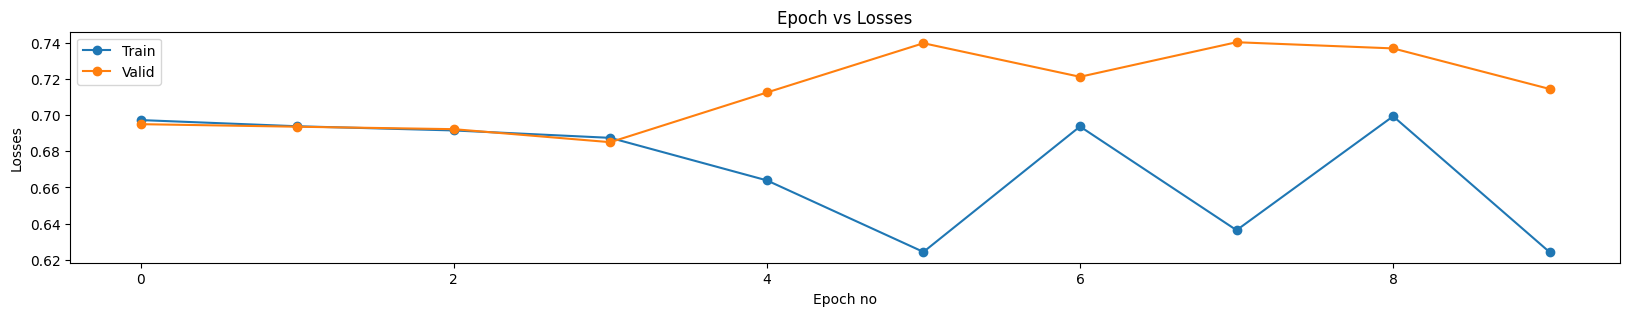

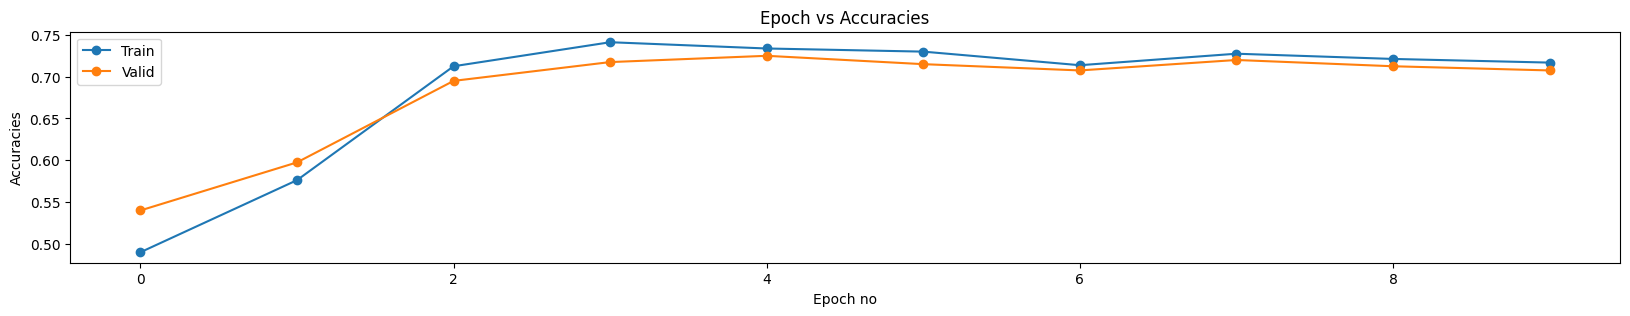

In [66]:
train_eval(sum_model, lr=0.001, max_epochs=10, plot_loss_acc=True, plot_batch_loss=False)